In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sys, os
import MySQLdb
from sshtunnel import SSHTunnelForwarder
sys.path.append(os.path.abspath("..")) 
from data_scraping.db_utils import get_connection
from IPython.display import display
from backtesting import Backtester

c:\Users\shane\AppData\Local\Programs\Python\Python312\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\shane\AppData\Local\Programs\Python\Python312\Lib\site-packages\paramiko\transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


### **Get DATA from SQL**

In [2]:
conn = MySQLdb.connect(
    host='127.0.0.1',
    port=3333,
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASSWORD"),
    db=os.getenv("DB_NAME")
)

cards_df = pd.read_sql("SELECT * FROM cards WHERE game = 26", conn)
sales_df = pd.read_sql("SELECT * FROM market_sales", conn)

df_26 = sales_df.merge(cards_df, on='card_id', how='left')

df_26 = df_26.sort_values('sale_time', ascending=False)

conn.close()

OperationalError: (2002, "Can't connect to server on '127.0.0.1' (10061)")

### **Dip Buy / Mean Reversion Strategy**

In [ ]:
platforms = ["pc", "ps"]  # you can add "xbox" later if needed

for plat in platforms:
    print(f"\n===== 📊 Platform: {plat.upper()} =====\n")

    recent_df = df_26[
        (df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(hours=12)) 
        & (df_26['sold_price'] > 0) 
        & (df_26['platform'] == plat)
        & (df_26['version'] == "Gold Rare")
    ]

    buy_candidates = []

    # Loop through each card
    for card_id, group in recent_df.groupby('card_id'):
        group = group.sort_values('sale_time', ascending=False)
        
        if len(group) >= 60:  # need enough sales for comparison
            last_short_avg = group.head(10)['sold_price'].mean()  # short-term average
            last_long_avg = group.head(100)['sold_price'].mean()   # longer-term average

            sales_volume = group.shape[0]

            # Check drop & liquidity
            if last_short_avg < 0.90 * last_long_avg and sales_volume >= 20 and last_short_avg >= 5000:
                buy_price = round(last_short_avg * 0.97)   # buy slightly below dip
                sell_price = round(last_long_avg * 0.98)  # sell slightly below average
                potential_profit = sell_price - buy_price
                drop_percent = (last_long_avg - last_short_avg) / last_long_avg * 100

                # --- Investment Rating ---
                if drop_percent >= 15 and (potential_profit / buy_price) * 100 >= 5 and sales_volume >= 30:
                    rating = "🔥 High"
                elif drop_percent >= 10 and (potential_profit / buy_price) * 100 >= 3 and sales_volume >= 20:
                    rating = "⚡ Medium"
                else:
                    rating = "⚠️ Low"

                buy_candidates.append({
                    "name": group.iloc[0]["name"],
                    "last_short_avg": round(last_short_avg, 2),
                    "last_long_avg": round(last_long_avg, 2),
                    "drop_%": round(drop_percent, 2),
                    "sales_volume": sales_volume,
                    "suggested_buy": buy_price,
                    "suggested_sell": sell_price,
                    "potential_profit": potential_profit,
                    "investment_rating": rating
                })
        else:
            continue  # skip cards with too few sales

    # Convert to DataFrame
    buy_df = pd.DataFrame(buy_candidates)

    if not buy_df.empty:
        buy_df = buy_df.sort_values(["investment_rating", "drop_%"], ascending=[False, False])
        print("🔥 Potential Buy Candidates with Ratings 🔥")
        print(buy_df.head(20))
    else:
        print("No buy candidates found with current filters.")



===== 📊 Platform: PC =====

🔥 Potential Buy Candidates with Ratings 🔥
             name  last_short_avg  last_long_avg  drop_%  sales_volume  \
0  Erling Haaland        306000.0       341400.0   10.37            80   

   suggested_buy  suggested_sell  potential_profit investment_rating  
0         296820          334572             37752          ⚡ Medium  

===== 📊 Platform: PS =====

No buy candidates found with current filters.


### Rising Cards Detector

In [ ]:
platforms = ["pc", "ps"]  # you can add "xbox" later if needed

for plat in platforms:
    print(f"\n===== 📊 Platform: {plat.upper()} =====\n")

    recent_df = df_26[
        (df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(hours=12)) 
        & (df_26['sold_price'] > 0) 
        & (df_26['platform'] == plat)
        & (df_26['version'] == "Gold Rare")
    ]

    rising_candidates = []

    for card_id, group in recent_df.groupby('card_id'):
        group = group.sort_values('sale_time', ascending=False)
        
        if len(group) >= 60:  # need enough sales for comparison
            last_short_avg = group.head(10)['sold_price'].mean()  # short-term average
            last_long_avg = group.head(200)['sold_price'].mean()   # longer-term average

            sales_volume = group.shape[0]

            # Check slow rise & liquidity
            if last_short_avg > 1.05 * last_long_avg and sales_volume >= 20:  # 5%+ rise
                suggested_buy = round(last_short_avg * 0.99)  # buy slightly below current price
                suggested_sell = round(last_short_avg * 1.03) # sell slightly above
                potential_profit = suggested_sell - suggested_buy
                rise_percent = (last_short_avg - last_long_avg) / last_long_avg * 100

                # --- Investment Rating ---
                if rise_percent >= 15 and (potential_profit / suggested_buy) * 100 >= 5 and sales_volume >= 30:
                    rating = "🔥 High"
                elif rise_percent >= 10 and (potential_profit / suggested_buy) * 100 >= 3 and sales_volume >= 20:
                    rating = "⚡ Medium"
                else:
                    rating = "⚠️ Low"

                rising_candidates.append({
                    "name": group.iloc[0]["name"],
                    "last_short_avg": round(last_short_avg, 2),
                    "last_long_avg": round(last_long_avg, 2),
                    "rise_%": round(rise_percent, 2),
                    "sales_volume": sales_volume,
                    "suggested_buy": suggested_buy,
                    "suggested_sell": suggested_sell,
                    "potential_profit": potential_profit,
                    "investment_rating": rating
                })
        else:
            continue  # skip cards with too few sales

    # Convert to DataFrame
    rising_df = pd.DataFrame(rising_candidates)

    if not rising_df.empty:
        rising_df = rising_df.sort_values(["investment_rating", "rise_%"], ascending=[False, False])
        print("📈 Potential Slow-Rising Cards 🔥")
        print(rising_df.head(20))
    else:
        print("No slow-rising candidates found with current filters.")



===== 📊 Platform: PC =====

📈 Potential Slow-Rising Cards 🔥
                           name  last_short_avg  last_long_avg  rise_%  \
47           Baris Alper Yilmaz          4210.0        2992.61   40.68   
83                Leon Goretzka          4790.0        4039.50   18.58   
21                  Yann Sommer          8380.0        7366.25   13.76   
74             Tabitha Chawinga         11125.0        9805.25   13.46   
55    Daniel Ceballos Fernandez           830.0         731.75   13.43   
70                  Selma Bacha         29450.0       26022.50   13.17   
59                 Manuel Neuer          3480.0        3081.25   12.94   
38              Youri Tielemans          2950.0        2616.43   12.75   
85  Joao Lucas de Souza Cardoso           820.0         727.88   12.66   
48                Karim Benzema          3920.0        3482.50   12.56   
40                Caitlin Foord          2810.0        2508.57   12.02   
12                 Kenan Yildiz          3270.0    

### **Low Volatility Sniping Strategy**

In [ ]:
# Filter last 24h of sales
recent_df = df_26[(df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(hours=24)) 
                  & (df_26['sold_price'] > 6000) 
                  & (df_26['platform'] == "pc")]

volatility_candidates = []

# Loop through each card
for name, group in recent_df.groupby('name'):
    group = group.sort_values('sale_time', ascending=False)
    
    if len(group) >= 200:  # need enough sales to judge stability
        last_200 = group.head(200)['sold_price']
        avg_price = last_200.mean()
        std_dev = last_200.std()
        cv = std_dev / avg_price  # coefficient of variation (volatility measure)
        lowest_sale = last_200.min()

        # Look for stability (low volatility) and dips
        if cv < 0.05 and (lowest_sale < 0.9 * avg_price):
            suggested_buy = round(lowest_sale * 0.97)  # safe buy price just above dip
            suggested_sell = round(avg_price * 0.98)   # safe exit slightly below avg
            ea_tax = round(suggested_sell * 0.05)      # EA 5% tax
            net_profit = suggested_sell - suggested_buy - ea_tax

            volatility_candidates.append({
                "name": name,
                "avg_price": round(avg_price, 2),
                "std_dev": round(std_dev, 2),
                "volatility_%": round(cv * 100, 2),
                "lowest_sale": lowest_sale,
                "undercut_%": round((avg_price - lowest_sale) / avg_price * 100, 2),
                "sales_volume": len(last_200),
                "suggested_buy": suggested_buy,
                "suggested_sell": suggested_sell,
                "net_profit": net_profit
            })

# Convert to DataFrame
vol_df = pd.DataFrame(volatility_candidates).sort_values("net_profit", ascending=False)

print("📉 Stable Cards with Undercuts (Low Volatility Snipes) 📉")
print(vol_df.head(20))


📉 Stable Cards with Undercuts (Low Volatility Snipes) 📉
                                name  avg_price  std_dev  volatility_%  \
15                     Florian Wirtz  289090.00  9666.91          3.34   
1              Alisson Ramses Becker   70367.50  3313.77          4.71   
21                   Jude Bellingham  178070.00  7259.38          4.08   
46                  Sakina Karchaoui   79390.00  3571.65          4.50   
11             Debora C. de Oliveira   55360.00  2426.00          4.38   
29  Maria Francesca Caldentey Oliver   65052.50  3070.12          4.72   
16                   Frenkie de Jong  185185.00  8257.22          4.46   
50                    Trinity Rodman   46340.00  2232.70          4.82   
51                    William Saliba  158110.00  5868.57          3.71   
22                  Kadidiatou Diani  168175.00  8030.37          4.78   
38       Patricia Guijarro Gutierrez  108120.00  4890.57          4.52   
45                  Ryan Gravenberch  103207.50  2668.58

### **Fluctuation Trading Strategy**

In [ ]:


# Focus on recent period (last 12h)
latest_time = df_26['sale_time'].max()
recent_df = df_26[
    (df_26['sale_time'] > latest_time - pd.Timedelta(hours=8)) &
    (df_26['platform'] == 'pc') &
    (df_26['sold_price'] > 1)
]

fluctuation_candidates = []

# Loop through each card
for name, group in recent_df.groupby("card_id"):
    group = group.sort_values('sale_time', ascending=False)
    latest_price = group.sort_values('sale_time', ascending=False)['sold_price'].head(5).median()
    
    # Skip if not enough recent sales
    if len(group) < 20:
        continue
    
    prices = group['sold_price'].sort_values()
    
    # Outlier removal: 5-95 percentile
    low = prices.quantile(0.05)
    high = prices.quantile(0.95)
    clean_prices = prices[(prices >= low) & (prices <= high)]
    
    # Cap all prices at latest sale to avoid outdated spikes
    clean_prices = clean_prices[clean_prices <= latest_price * 1.05]
    
    if clean_prices.empty:
        continue
    
    avg_price = clean_prices.mean()
    min_price = clean_prices.min()
    max_price = clean_prices.max()
    spread = (max_price - min_price) / avg_price * 100
    sales_volume = len(clean_prices)
    
    # Only consider truly fluctuating cards
    if spread >= 15 and sales_volume >= 20 and avg_price > 5000:
        buy_price = round(min_price * 1.02)      # buy slightly above min
        sell_price = round(avg_price * 0.98)    # sell slightly below avg
        profit_margin = round(((sell_price - buy_price) / buy_price) * 100, 2)
        
        # Only recommend if profit margin is worthwhile and below latest sale
        if profit_margin > 5 and buy_price <= latest_price:
            fluctuation_candidates.append({
                "name": group.iloc[0]["name"],
                "latest_sale": latest_price,
                "avg_price": int(avg_price),
                "min_price": int(min_price),
                "max_price": int(max_price),
                "spread_%": round(spread, 2),
                "sales_volume": sales_volume,
                "best_buy": buy_price,
                "best_sell": sell_price,
                "profit_margin_%": profit_margin,
            })

# Convert to DataFrame and sort
fluctuation_df = pd.DataFrame(fluctuation_candidates).sort_values(
    "profit_margin_%", ascending=False
)

print("📊 Fluctuation Trading Recommendations 📊")
print(fluctuation_df.head(20))


📊 Fluctuation Trading Recommendations 📊
                             name  latest_sale  avg_price  min_price  \
22          Daniel Carvajal Ramos       6000.0       5367       4400   
9   Bruno Miguel Borges Fernandes      12500.0      11704       9700   
0                      Harry Kane      25500.0      23862      20000   
8                     Yann Sommer       8300.0       7484       6400   
31                   Felix Nmecha       8900.0       8127       7000   
1                   Ada Hegerberg       6800.0       6370       5500   
29          David De Gea Quintana       7700.0       7502       6500   
16                  Mayra Ramirez      11750.0      10836       9400   
3                   Alessia Russo      16750.0      15745      13750   
20          Roger Ibanez da Silva      26000.0      24391      21500   
26                    Selma Bacha      29500.0      26606      23500   
30               Tabitha Chawinga      11250.0      10149       9000   
24                Alphon

### ICON Fluctuation Trading

In [ ]:
# Focus on recent period (last 12h)
latest_time = df_26['sale_time'].max()
recent_df = df_26[
    (df_26['sale_time'] > latest_time - pd.Timedelta(hours=12)) &
    (df_26['platform'] == 'pc') &
    (df_26['sold_price'] > 1) &
    (df_26['version'] == "All Icons")  # only icons
]

fluctuation_candidates = []

# Loop through each icon card
for card_id, group in recent_df.groupby("card_id"):
    if len(group) < 5:  # lower threshold since icons are rare
        continue

    # Robust latest price: median of last 3–5 sales
    latest_price = group.sort_values('sale_time', ascending=False)['sold_price'].head(5).median()
    latest_name = group.sort_values('sale_time', ascending=False).iloc[0]['name']

    prices = group['sold_price'].sort_values()
    
    # Outlier removal: 5-95 percentile
    low, high = prices.quantile(0.05), prices.quantile(0.95)
    clean_prices = prices[(prices >= low) & (prices <= high)]
    
    # Cap at latest sale to avoid outdated spikes
    clean_prices = clean_prices[clean_prices <= latest_price * 1.05]
    
    if clean_prices.empty:
        continue
    
    avg_price = clean_prices.mean()
    min_price = clean_prices.min()
    max_price = clean_prices.max()
    spread = (max_price - min_price) / avg_price * 100
    sales_volume = len(clean_prices)
    
    # Relaxed fluctuation criteria for rare icons
    if spread >= 5 and sales_volume >= 5 and avg_price > 5000:
        buy_price = round(min_price * 1.02)
        sell_price = round(avg_price * 0.98)
        profit_margin = round((sell_price - buy_price) / buy_price * 100, 2)
        
        if profit_margin > 5 and buy_price <= latest_price:
            fluctuation_candidates.append({
                "name": latest_name,
                "latest_sale": latest_price,
                "avg_price": int(avg_price),
                "min_price": int(min_price),
                "max_price": int(max_price),
                "spread_%": round(spread, 2),
                "sales_volume": sales_volume,
                "best_buy": buy_price,
                "best_sell": sell_price,
                "profit_margin_%": profit_margin,
            })

# Convert to DataFrame and sort safely
fluctuation_df = pd.DataFrame(fluctuation_candidates)
if not fluctuation_df.empty:
    fluctuation_df = fluctuation_df.sort_values("profit_margin_%", ascending=False)
    print("📊 Icon Fluctuation Trading Recommendations 📊")
    print(fluctuation_df.head(20))
else:
    print("No icon fluctuation candidates found in the last 12h.")


No icon fluctuation candidates found in the last 12h.


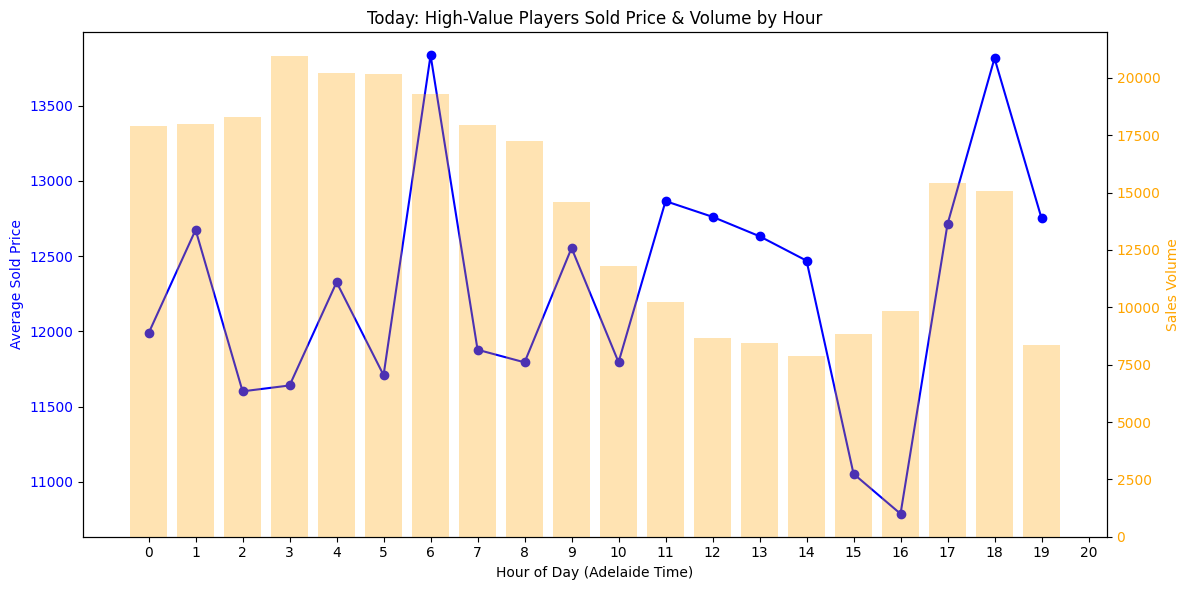

In [ ]:
# Assuming df_26['sale_time'] is already in Adelaide timezone
adelaide_tz = df_26['sale_time'].dt.tz

# Yesterday's start and end
yesterday_start = pd.Timestamp.now(tz=adelaide_tz).normalize() - pd.Timedelta(days=0)
yesterday_end = yesterday_start + pd.Timedelta(days=1)

# Filter only yesterday
yesterday_df = df_26[
    (df_26['sale_time'] >= yesterday_start) &
    (df_26['sale_time'] < yesterday_end)
]



pc_yesterday_df = yesterday_df[(yesterday_df['platform'] == "pc")  & (yesterday_df['version'] == "Gold Rare")]


# Calculate hourly average sold price
hourly_stats = pc_yesterday_df.groupby(pc_yesterday_df['sale_time'].dt.hour)['sold_price'].agg(['median','count']).reset_index()
hourly_stats = hourly_stats.sort_values('sale_time')

hourly_avg = pc_yesterday_df.groupby(pc_yesterday_df['sale_time'].dt.hour)['sold_price'].mean().reset_index()
hourly_avg = hourly_avg.sort_values('sale_time')

# Group by hour
hourly = pc_yesterday_df.groupby(pc_yesterday_df['sale_time'].dt.hour).agg({
    'sold_price': 'mean',
    'name': 'count'  # count of sales as volume
}).reset_index().rename(columns={'name': 'sales_volume'})

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Sold price line
ax1.plot(hourly['sale_time'], hourly['sold_price'], color='blue', marker='o', label='Average Sold Price')
ax1.set_xlabel("Hour of Day (Adelaide Time)")
ax1.set_ylabel("Average Sold Price", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(0,24))

# Volume bars
ax2 = ax1.twinx()
ax2.bar(hourly['sale_time'], hourly['sales_volume'], color='orange', alpha=0.3, label='Sales Volume')
ax2.set_ylabel("Sales Volume", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Today: High-Value Players Sold Price & Volume by Hour")
fig.tight_layout()
plt.show()

### BackTesting

In [ ]:
import pandas as pd
from datetime import timedelta

# --- prepare data window & clean ---
df_26['sale_time'] = pd.to_datetime(df_26['sale_time'])
df_26 = df_26[df_26['platform'] == "pc"]
# window: yesterday -> today (you can change)
today = df_26['sale_time'].max().normalize()
yesterday = today - pd.Timedelta(days=4)
df_window = df_26[(df_26['sale_time'] >= yesterday) & (df_26['sale_time'] < today + pd.Timedelta(days=1))]


# clean obvious junk/outliers
def clean_group(g):
    g = g[g['sold_price'].notnull() & (g['sold_price'] > 200)]
    if len(g) < 10:
        return g
    low = g['sold_price'].quantile(0.05)
    high = g['sold_price'].quantile(0.95)
    return g[(g['sold_price'] >= low) & (g['sold_price'] <= high)]
df_clean = df_window.groupby('name', group_keys=False)\
                    .apply(clean_group)\
                    .reset_index(drop=True)

# compute per-card stats to use for checks
card_stats = df_clean.groupby('name')['sold_price'].agg(['median','max','quantile'])
# NOTE: .quantile here is not correct for groupby agg; we will compute 99th separately
q99 = df_clean.groupby('name')['sold_price'].quantile(0.99).rename('q99')
median = df_clean.groupby('name')['sold_price'].median().rename('median')
card_stats = pd.concat([median, q99], axis=1).fillna(0)

# --- Robust Backtester ---
class RobustBacktester:
    def __init__(self, df, tax=0.05, min_buy=200):
        self.df = df.sort_values('sale_time').reset_index(drop=True)
        self.tax = tax
        self.min_buy = min_buy
        self.trades = []
        self.suspicious = []

    def run_for_card(self, card_id, buy_rule, sell_rule):
        df = self.df[self.df['card_id'] == card_id].sort_values('sale_time').reset_index(drop=True)
        card_name = df['name'].iloc[0]
        trades = []
        for i, row in df.iterrows():
            # sell_price observed at row
            cur_sold = row['sold_price']
            # listed price may exist in your data
            listed = row.get('listed_price', None)
            signal, buy_price = buy_rule(df, i)

            # make buy decision ONLY from past (rows < i)
            if signal:
                # sanity: skip if buy_price <= min or obviously invalid
                if buy_price is None or buy_price <= self.min_buy:
                    continue

                trade = {
                    "card": df.loc[i, "name"],
                    "buy_time": df.loc[i, "sale_time"],      # ✅ same row as signal
                    "buy_price": buy_price,                    # ✅ from signal itself
                    "sell_time": None,
                    "sell_price": None,
                    "profit": None
                }
                trades.append(trade)


            else:
                # decide to sell
                if sell_rule(df, i, holding['buy_price']):
                    sell_price = cur_sold
                    net_sell = sell_price * (1 - self.tax)
                    profit = net_sell - holding['buy_price']
                    hold_hours = (row['sale_time'] - holding['buy_time']).total_seconds() / 3600.0

                    # sanity check: if sell_price > card 99th percentile by big margin, flag it
                    q99_price = card_stats.loc[card_name, 'q99'] if card_name in card_stats.index else None
                    if q99_price and sell_price > 1.5 * q99_price:
                        self.suspicious.append({
                            'card': card_name, 'buy_price': holding['buy_price'],
                            'sell_price': sell_price, 'sell_time': row['sale_time'],
                            'reason': 'sell >> q99'
                        })
                        # you can choose to skip adding this trade or add with flag.
                        # Here we still record but mark it
                        self.trades.append({'card':card_name,'buy_time':holding['buy_time'],
                                            'buy_price':holding['buy_price'],
                                            'sell_time':row['sale_time'],'sell_price':sell_price,
                                            'profit':profit,'hold_hours':hold_hours,'suspicious':True})
                    else:
                        self.trades.append({'card':card_name,'buy_time':holding['buy_time'],
                                            'buy_price':holding['buy_price'],
                                            'sell_time':row['sale_time'],'sell_price':sell_price,
                                            'profit':profit,'hold_hours':hold_hours,'suspicious':False})
                    holding = None

        return pd.DataFrame(self.trades), pd.DataFrame(self.suspicious)

# --- Example buy/sell rules (conservative) ---

def buy_rule_panic_dip(df, idx):
    if idx < 30:
        return False, None

    window = df.loc[max(0, idx-30):idx-1, 'sold_price']
    median_price = window.median()
    std_dev = window.std()
    cur = df.loc[idx, 'sold_price']

    if (
        pd.notnull(cur)
        and cur <= 0.85 * median_price
        and cur > 0.5 * median_price
        and std_dev / median_price < 0.08
    ):
        print("🔥 PANIC DIP BUY", df.loc[idx, 'sale_time'], cur, "vs median", median_price)
        return True, cur
    return False, None



def sell_rule_rebound(df, idx, buy_price):
    window = df.loc[max(0, idx-30):idx-1, 'sold_price']
    median_price = window.median()
    cur = df.loc[idx, 'sold_price']
    if pd.isnull(cur):
        return False
    # normal rebound sell
    if cur >= 0.97 * median_price:
        return True
    # stop-loss: cut if price falls another 10% from buy
    if cur <= 0.90 * buy_price:
        return True
    return False



# --- Run backtest for the suspicious card ---
bt = RobustBacktester(df_clean, tax=0.05, min_buy=200)
trades_df, suspicious_df = bt.run_for_card(1009, buy_rule_panic_dip, sell_rule_rebound)

print(trades_df.head(20))
print("Suspicious trades flagged:")
print(suspicious_df.head(20))
print("Total Profit:", trades_df['profit'].sum() if not trades_df.empty else 0.0)


C:\Users\shane\AppData\Local\Temp\ipykernel_12492\3533954825.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(clean_group)\


UnboundLocalError: cannot access local variable 'holding' where it is not associated with a value

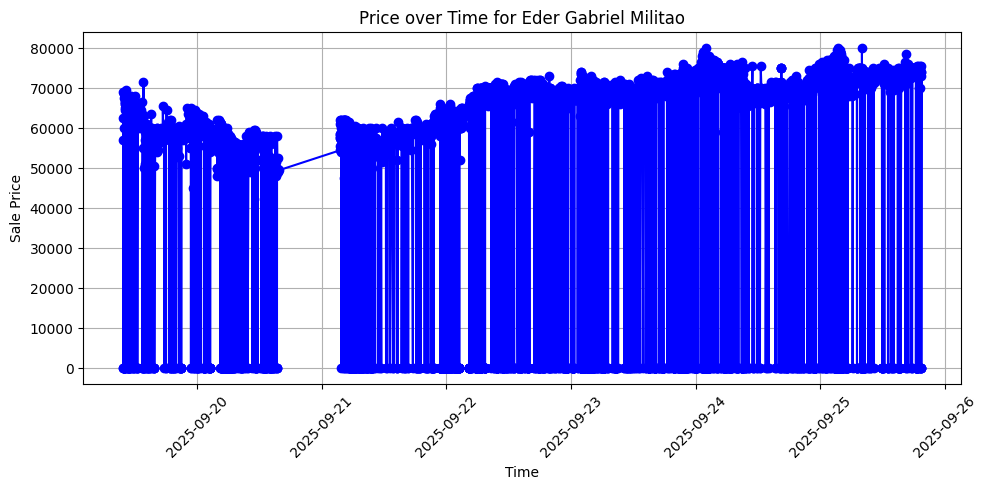

In [ ]:
import matplotlib.pyplot as plt

def plot_player_sales(card_id, df):
    """
    Plot sales price and volume over time for a given player card_id.
    """
    # Filter the data for this card
    player_df = df[df['card_id'] == card_id].sort_values('sale_time')

    if player_df.empty:
        print(f"No sales data found for card_id {card_id}")
        return

    # Get player name (assuming all rows have the same name)
    player_name = player_df['name'].iloc[0]

    # Sale times and prices
    times = player_df['sale_time']
    prices = player_df['sold_price']

    # Sales volume per hour
    volume = player_df.groupby(player_df['sale_time'].dt.floor('H')).size()

    # Create plot
    fig, ax1 = plt.subplots(figsize=(12,6))

    # Price line
    ax1.plot(times, prices, color='blue', marker='o', linestyle='-', label='Price')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Volume bars
    ax2 = ax1.twinx()
    ax2.bar(volume.index, volume.values, color='orange', alpha=0.3, label='Volume')
    ax2.set_ylabel('Sales Volume', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Title and layout
    plt.title(f"Sales Price & Volume for {player_name}")
    fig.tight_layout()
    plt.show()

# Example usage
plot_player_sales(811, df_26)


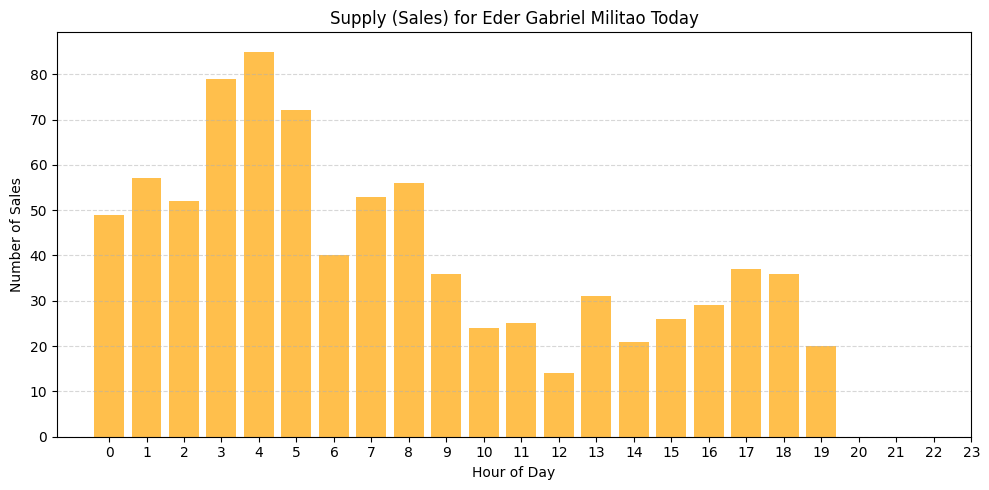

In [ ]:
def plot_supply_today_by_card(card_id, df):
    """
    Plot number of sales (supply) for a given card_id today.
    """
    # Filter for the card and today's sales
    today = pd.Timestamp.now().normalize()  # start of today
    card_df = df[
        (df['card_id'] == card_id) &
        (df['sale_time'] >= today)
    ]

    if card_df.empty:
        print(f"No sales today for card_id {card_id}")
        return

    # Get player name for title
    player_name = card_df['name'].iloc[0]

    # Count sales per hour
    supply_per_hour = card_df.groupby(card_df['sale_time'].dt.hour).size()

    # Plot
    plt.figure(figsize=(10,5))
    plt.bar(supply_per_hour.index, supply_per_hour.values, color='orange', alpha=0.7)
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Sales")
    plt.title(f"Supply (Sales) for {player_name} Today")
    plt.xticks(range(0,24))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage
plot_supply_today_by_card(811, df_26)


C:\Users\shane\AppData\Local\Temp\ipykernel_12492\3051181390.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shane\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


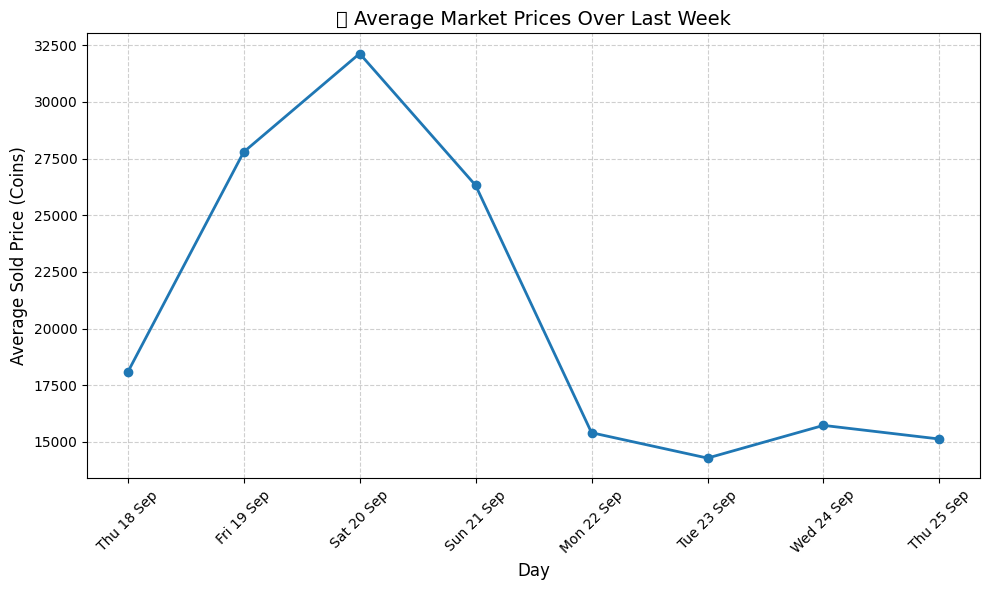

In [ ]:
# Ensure datetime
df_26['sale_time'] = pd.to_datetime(df_26['sale_time'])

# Last 7 days only
last_week = df_26[df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(days=7)]

# Group by day
daily_avg = last_week.groupby(last_week['sale_time'].dt.date)['sold_price'].mean()

# Plot
plt.figure(figsize=(10,6))
plt.plot(daily_avg.index, daily_avg.values, marker='o', linewidth=2)

# Labels
plt.title("📊 Average Market Prices Over Last Week", fontsize=14)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Average Sold Price (Coins)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Format x-axis: show both date and weekday
plt.xticks(daily_avg.index, 
           [pd.to_datetime(d).strftime('%a %d %b') for d in daily_avg.index], 
           rotation=45)

plt.tight_layout()
plt.show()